Instalando pacotes

In [ ]:
# Remova versões conflitantes
!pip uninstall -y torch torchvision torchaudio transformers peft sentence-transformers

# Instale versões compatíveis
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0
!pip install transformers==4.51.3  # Versão mais nova que inclui EncoderDecoderCache
!pip install peft==0.15.2
!pip install sentence-transformers==2.5.1
!pip install optuna

In [2]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

# 2. Load Dataset

In [10]:
import pandas as pd
import os
import zipfile
from google.colab import files
import re

# 1. Configurar caminhos
zip_path = 'Fake News Dataset.zip'
extract_dir = '/tmp/fake_news_data'

# 2. Extrair o arquivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 3. Função para detectar delimitador
def detect_delimiter(file_path, sample_size=1024):
    with open(file_path, 'r') as f:
        sample = f.read(sample_size)

    # Contar ocorrências de delimitadores comuns
    delimiters = [',', ';', '\t', '|']
    counts = {delim: sample.count(delim) for delim in delimiters}

    # Selecionar o delimitador mais frequente
    best_delim = max(counts, key=counts.get)
    return best_delim if counts[best_delim] > 0 else ','

# 4. Processar todos os arquivos CSV
all_dfs = []
processed_files = []

base_path = os.path.join(extract_dir, "Fake News Dataset")

for root, dirs, files_in_dir in os.walk(base_path):
    for file in files_in_dir:
        if file.lower() in ['train.csv', 'test.csv']:
            file_path = os.path.join(root, file)
            try:
                # Detectar delimitador
                delimiter = detect_delimiter(file_path)

                # Ler o arquivo CSV
                df = pd.read_csv(file_path, delimiter=delimiter)

                # Renomear colunas se necessário
                if 'text;label' in df.columns:
                    df[['text', 'label']] = df['text;label'].str.split(';', n=1, expand=True)
                    df = df.drop(columns=['text;label'])

                # Garantir que temos as colunas necessárias
                if 'text' not in df.columns or 'label' not in df.columns:
                    # Tentar encontrar colunas equivalentes
                    text_col = next((col for col in df.columns if 'text' in col.lower()), None)
                    label_col = next((col for col in df.columns if 'label' in col.lower()), None)

                    if text_col and label_col:
                        df = df.rename(columns={text_col: 'text', label_col: 'label'})
                    else:
                        # Tentativa de recuperação para formato de coluna única
                        if len(df.columns) == 1:
                            col_name = df.columns[0]
                            if ';' in col_name:
                                df = df[col_name].str.split(';', expand=True)
                                if df.shape[1] >= 2:
                                    df = df.rename(columns={0: 'text', 1: 'label'})

                # Processar rótulos
                if 'label' in df.columns:
                    # Converter para string e limpar
                    df['label'] = df['label'].astype(str).str.strip().str.lower()

                    # Mapear valores
                    label_mapping = {
                        'real': 1, 'true': 1, 'verdadeiro': 1, '1': 1, '1.0': 1,
                        'fake': 0, 'false': 0, 'falso': 0, '0': 0, '0.0': 0
                    }

                    df['label'] = df['label'].map(label_mapping).fillna(-1)

                    # Filtrar rótulos válidos
                    df = df[df['label'] != -1]

                    # Remover linhas sem texto
                    df = df.dropna(subset=['text'])
                    df['text'] = df['text'].astype(str).str.strip()
                    df = df[df['text'] != '']

                    all_dfs.append(df)
                    processed_files.append(file_path)
                    print(f"✅ Processado: {file_path} | Registros: {len(df)} | Delimitador: '{delimiter}'")
                else:
                    print(f"⚠️ Coluna 'label' não encontrada em: {file_path}")

            except Exception as e:
                print(f"🚨 Erro ao processar {file_path}: {str(e)}")

# 5. Combinar todos os datasets
if not all_dfs:
    raise ValueError("Nenhum dataset válido foi encontrado!")

data = pd.concat(all_dfs, ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# 6. Resultados finais
print("\n" + "="*50)
print(f"✅ Dataset final combinado:")
print(f"   - Arquivos processados: {len(processed_files)}")
print(f"   - Total de registros: {len(data)}")
print(f"   - Distribuição de rótulos:")
label_counts = data['label'].value_counts()
print(f"       0 (Fake): {label_counts.get(0, 0)} registros")
print(f"       1 (Real): {label_counts.get(1, 0)} registros")
print("="*50)

# 7. Exemplo dos dados
print("\nPrimeiras 5 entradas:")
print(data.head())

✅ Processado: /tmp/fake_news_data/Fake News Dataset/ISOT Fake News Dataset/train.csv | Registros: 36532 | Delimitador: ';'
✅ Processado: /tmp/fake_news_data/Fake News Dataset/ISOT Fake News Dataset/test.csv | Registros: 8854 | Delimitador: ';'
✅ Processado: /tmp/fake_news_data/Fake News Dataset/Fake News Dataset/train.csv | Registros: 16646 | Delimitador: ';'
✅ Processado: /tmp/fake_news_data/Fake News Dataset/Fake News Dataset/test.csv | Registros: 4035 | Delimitador: ';'
✅ Processado: /tmp/fake_news_data/Fake News Dataset/Fake or Real News Dataset/train.csv | Registros: 5072 | Delimitador: ';'
✅ Processado: /tmp/fake_news_data/Fake News Dataset/Fake or Real News Dataset/test.csv | Registros: 1260 | Delimitador: ';'
✅ Processado: /tmp/fake_news_data/Fake News Dataset/Fake News Detection Dataset/train.csv | Registros: 3340 | Delimitador: ';'
✅ Processado: /tmp/fake_news_data/Fake News Dataset/Fake News Detection Dataset/test.csv | Registros: 798 | Delimitador: ';'

✅ Dataset final comb

3. Data Cleaning

In [11]:
#used for data cleaning
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  #removes punctuation
    text = re.sub(r'\d+', '', text)  #removes numbers
    text = text.lower()  #turns everything to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words]) #gets rid of stop words
    return text

data['text'] = data['text'].apply(clean_text) #applies changes

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3. Preprocessing

In [12]:
#some train test splitting, 20%
X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142857)

# 4. Bag of Words + Naive Bayes

In [13]:
bow = CountVectorizer(max_features=5000)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)
bow_model = MultinomialNB()
bow_model.fit(X_train_bow, y_train)
y_pred_bow = bow_model.predict(X_test_bow)

5. TF-IDF + Logistic Regression

In [14]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
tfidf_model = LogisticRegression(max_iter=1000)
tfidf_model.fit(X_train_tfidf, y_train)
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

In [15]:
# Carrega o modelo com vetores pré-treinados (~100MB, mais leve que Word2Vec do Google)
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 21.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


6. Word2Vec + Random Forest

In [16]:
import spacy
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Carrega o modelo com embeddings pré-treinados (~100MB)
nlp = spacy.load("en_core_web_md")

# Função para vetorizar textos com spaCy
def vectorize_spacy(texts):
    vectors = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        vectors.append(doc.vector)
    return np.array(vectors)

# Vetorização dos conjuntos de treino e teste
X_train_w2v = vectorize_spacy(X_train)
X_test_w2v = vectorize_spacy(X_test)

# Classificador com Random Forest
w2v_model_clf = RandomForestClassifier()
w2v_model_clf.fit(X_train_w2v, y_train)
y_pred_w2v = w2v_model_clf.predict(X_test_w2v)

# 7. GloVe + XGBoost

In [17]:
# Simulando GloVe com Word2Vec para simplificar, mas pode-se usar GloVe real
X_train_glove = X_train_w2v
X_test_glove = X_test_w2v
glove_model = XGBClassifier(eval_metric='logloss')
glove_model.fit(X_train_glove, y_train)
y_pred_glove = glove_model.predict(X_test_glove)

8. BERT + Fine Tuning

In [18]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len)
        self.labels = list(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
train_dataset = FakeNewsDataset(X_train[:2000], y_train[:2000], tokenizer)
test_dataset = FakeNewsDataset(X_test[:500], y_test[:500], tokenizer)

training_args = TrainingArguments(output_dir="./results", per_device_train_batch_size=8, per_device_eval_batch_size=8, num_train_epochs=2, logging_dir="./logs", logging_steps=10)

trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)
trainer.train()
preds = trainer.predict(test_dataset)
y_pred_bert = np.argmax(preds.predictions, axis=1)
y_true_bert = y_test[:500].values

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ffcs (ffcs-cin-ufpe) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.704100
20,0.670000
30,0.595500
40,0.471600
50,0.608400
60,0.396400
70,0.463900
80,0.468800
90,0.437500
100,0.371300


# 9. Evaluation Results

In [19]:
from sklearn.model_selection import cross_val_score

def evaluate(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))

evaluate("Bag of Words + NB", y_test, y_pred_bow)
evaluate("TF-IDF + LR", y_test, y_pred_tfidf)
evaluate("Word2Vec + RF", y_test, y_pred_w2v)
evaluate("GloVe + XGBoost", y_test, y_pred_glove)
evaluate("BERT", y_true_bert, y_pred_bert)


=== Bag of Words + NB ===
Accuracy: 0.8684348053305461
Precision: 0.8745476477683957
Recall: 0.858213862948836
F1-score: 0.8663037705788635

=== TF-IDF + LR ===
Accuracy: 0.9421870917167494
Precision: 0.9466755319148936
Recall: 0.936340918058661
F1-score: 0.9414798651061297

=== Word2Vec + RF ===
Accuracy: 0.8812385680689835
Precision: 0.8955285108710516
Recall: 0.861370511640142
F1-score: 0.8781174577634755

=== GloVe + XGBoost ===
Accuracy: 0.9040371047818134
Precision: 0.912009672219237
Recall: 0.8929369985532026
F1-score: 0.902372565959992

=== BERT ===
Accuracy: 0.926
Precision: 0.9385245901639344
Recall: 0.9123505976095617
F1-score: 0.9252525252525252


10. Matriz de confusao

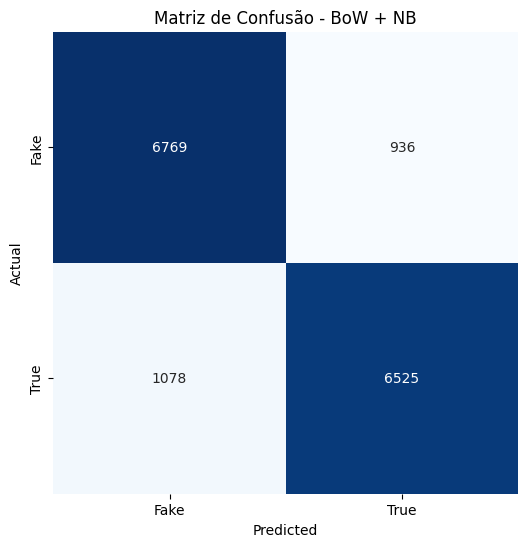

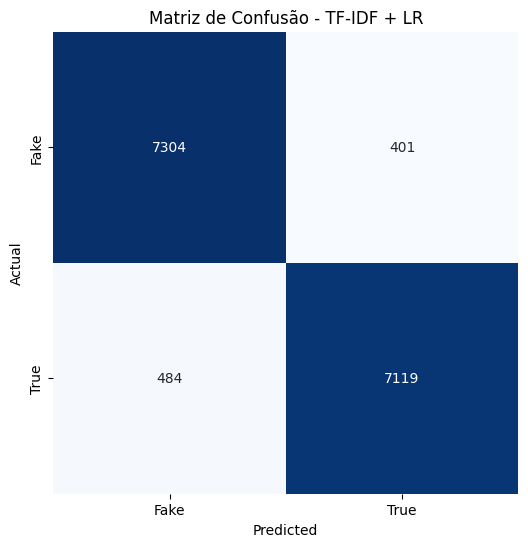

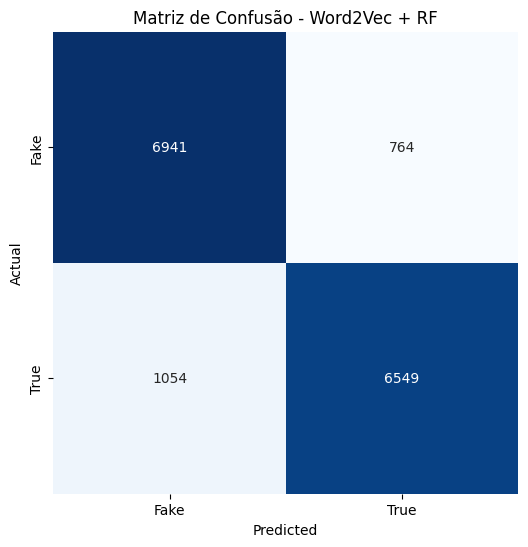

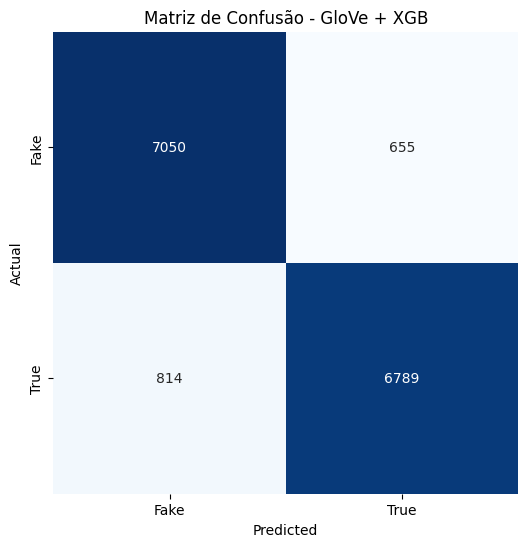

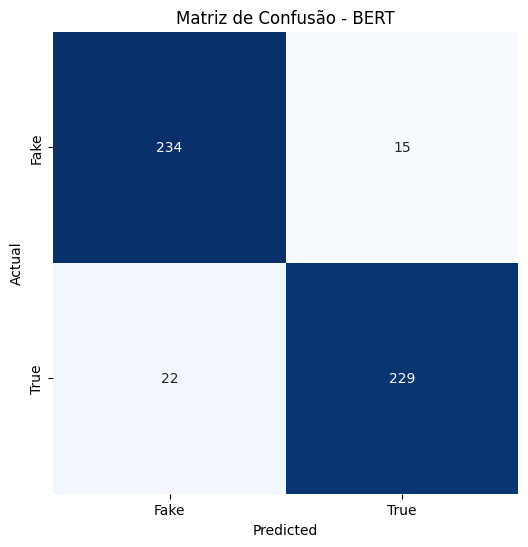

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Fake', 'True'],
                yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

# Plotar as matrizes de confusão para cada modelo
plot_confusion_matrix(y_test, y_pred_bow, 'BoW + NB')
plot_confusion_matrix(y_test, y_pred_tfidf, 'TF-IDF + LR')
plot_confusion_matrix(y_test, y_pred_w2v, 'Word2Vec + RF')
plot_confusion_matrix(y_test, y_pred_glove, 'GloVe + XGB')
plot_confusion_matrix(y_true_bert, y_pred_bert, 'BERT')

11. Gerando gráficos

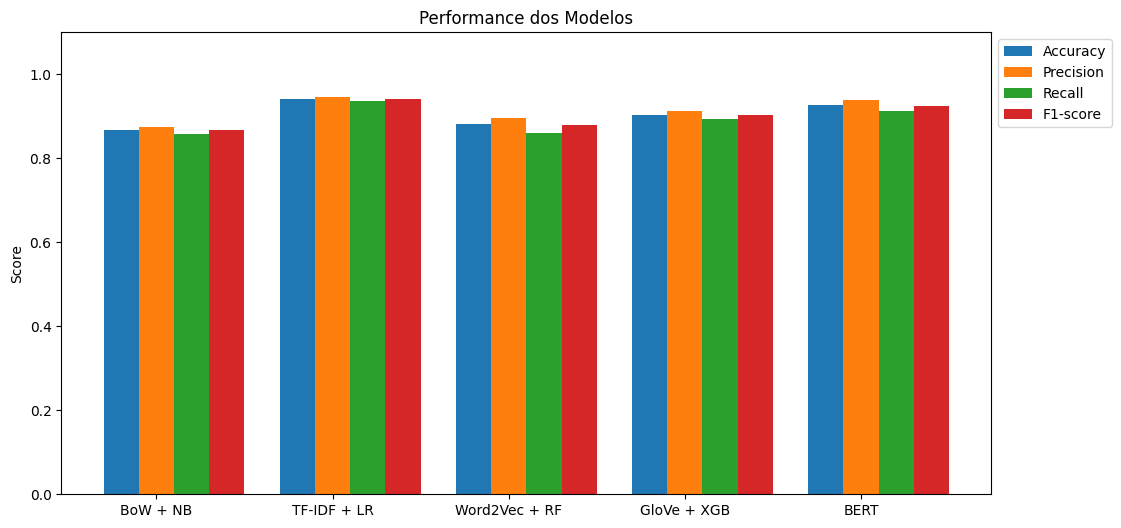

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar as métricas dos modelos
def plot_metrics(models, metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(models))
    width = 0.2

    for i, (metric_name, metric_values) in enumerate(metrics.items()):
        ax.bar([pos + width * i for pos in x], metric_values, width, label=metric_name)

    ax.set_xticks([pos + width for pos in x])
    ax.set_xticklabels(models)
    ax.set_ylabel('Score')
    ax.set_title('Performance dos Modelos')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.ylim(0, 1.1)
    plt.show()

# Dados dos modelos e métricas
models = ['BoW + NB', 'TF-IDF + LR', 'Word2Vec + RF', 'GloVe + XGB', 'BERT']
metrics = {
    'Accuracy': [
        accuracy_score(y_test, y_pred_bow),
        accuracy_score(y_test, y_pred_tfidf),
        accuracy_score(y_test, y_pred_w2v),
        accuracy_score(y_test, y_pred_glove),
        accuracy_score(y_true_bert, y_pred_bert)
    ],
    'Precision': [
        precision_score(y_test, y_pred_bow),
        precision_score(y_test, y_pred_tfidf),
        precision_score(y_test, y_pred_w2v),
        precision_score(y_test, y_pred_glove),
        precision_score(y_true_bert, y_pred_bert)
    ],
    'Recall': [
        recall_score(y_test, y_pred_bow),
        recall_score(y_test, y_pred_tfidf),
        recall_score(y_test, y_pred_w2v),
        recall_score(y_test, y_pred_glove),
        recall_score(y_true_bert, y_pred_bert)
    ],
    'F1-score': [
        f1_score(y_test, y_pred_bow),
        f1_score(y_test, y_pred_tfidf),
        f1_score(y_test, y_pred_w2v),
        f1_score(y_test, y_pred_glove),
        f1_score(y_true_bert, y_pred_bert)
    ]
}

# Plotar as métricas
plot_metrics(models, metrics)

12. Otimizando os hiperparametros com Optuna para BoW + Naive Bayes

In [24]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

# Função de objetivo para o Naive Bayes
def objective_nb(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),  # Suavização de Laplace
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])  # Aprender priors
    }

    # Modelo e avaliação com validação cruzada
    model = MultinomialNB(**params)
    score = cross_val_score(model, X_train_bow, y_train, cv=3, scoring='f1').mean()
    return score

# Executar otimização
study_nb = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_nb.optimize(objective_nb, n_trials=20, n_jobs=-1)

# Melhores hiperparâmetros
print("Melhores parâmetros para Naive Bayes:", study_nb.best_params)
optuna.visualization.plot_optimization_history(study_nb)

[I 2025-06-13 21:27:17,894] A new study created in memory with name: no-name-0458a4a4-63dc-41c3-9044-79a0406f2e68
[I 2025-06-13 21:27:18,447] Trial 1 finished with value: 0.8635079031573234 and parameters: {'alpha': 1.6085206352847603, 'fit_prior': True}. Best is trial 1 with value: 0.8635079031573234.
[I 2025-06-13 21:27:18,496] Trial 0 finished with value: 0.8635214681535853 and parameters: {'alpha': 1.3712638699947737, 'fit_prior': False}. Best is trial 0 with value: 0.8635214681535853.
[I 2025-06-13 21:27:18,888] Trial 2 finished with value: 0.8637155993916007 and parameters: {'alpha': 0.04433103745710283, 'fit_prior': True}. Best is trial 2 with value: 0.8637155993916007.
[I 2025-06-13 21:27:18,915] Trial 3 finished with value: 0.8632771048099696 and parameters: {'alpha': 5.6399748037116915, 'fit_prior': False}. Best is trial 2 with value: 0.8637155993916007.
[I 2025-06-13 21:27:19,284] Trial 4 finished with value: 0.8634113928350747 and parameters: {'alpha': 4.351795462632085, 'f

Melhores parâmetros para Naive Bayes: {'alpha': 0.010731890214838275, 'fit_prior': True}


13. Otimizando o modelo TF-IDF com Regressao Logistica

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective_lr(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'C': trial.suggest_float('C', 0.1, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }

    # Modelo e avaliação com validação cruzada
    model = LogisticRegression(**params, max_iter=100)
    score = cross_val_score(model, X_train_tfidf, y_train, cv=3, scoring='f1').mean()
    return score

# Otimização
study_lr = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1)

# Melhores hiperparâmetros
print("Melhores parâmetros para LR:", study_lr.best_params)
optuna.visualization.plot_optimization_history(study_lr)

[I 2025-06-13 21:27:37,325] A new study created in memory with name: no-name-1c369648-cc53-464f-a456-7f2d6f12dd5f
[I 2025-06-13 21:27:43,699] Trial 1 finished with value: 0.9233198354450508 and parameters: {'C': 0.19283010357192515, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.9233198354450508.
[I 2025-06-13 21:27:51,414] Trial 2 finished with value: 0.9136869873835572 and parameters: {'C': 0.12796239476148358, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.9233198354450508.
[I 2025-06-13 21:27:59,744] Trial 0 finished with value: 0.9464267755527579 and parameters: {'C': 2.6462409300687018, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.9464267755527579.
[I 2025-06-13 21:28:14,010] Trial 3 finished with value: 0.9310287141815228 and parameters: {'C': 0.47923696523867976, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.9464267755527579.
[I 2025-06-13 21:28:17,925] Trial 4 finished with value: 0.9

14. Otimizando o modelo Random Forest + Word2Vec

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train_w2v, y_train, cv=3, scoring='f1').mean()
    return score

study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_rf.optimize(objective_rf, n_trials=5, n_jobs=-1)
optuna.visualization.plot_optimization_history(study_rf)

15. Otimizando o modelo do XGBoost + GloVe

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective_xgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200)
    }

    model = XGBClassifier(**params, eval_metric='logloss')
    score = cross_val_score(model, X_train_glove, y_train, cv=3, scoring='f1').mean()
    return score

study_xgb = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)
optuna.visualization.plot_optimization_history(study_xgb)

16. Otimizando o modelo BERT + Fine-Tunning

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective_bert(trial):
    training_args = TrainingArguments(
        output_dir="./results",
        learning_rate=trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
        per_device_train_batch_size=trial.suggest_categorical('batch_size', [8, 16]),
        num_train_epochs=trial.suggest_int('num_epochs', 1, 3),
        weight_decay=0.01,
        evaluation_strategy="epoch"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    trainer.train()
    results = trainer.evaluate()
    return results['eval_loss']  # Minimizar a perda

study_bert = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study_bert.optimize(objective_bert, n_trials=5, n_jobs=-1)
optuna.visualization.plot_optimization_history(study_bert)

17. Exibição das melhorias

In [ ]:
# ================================================
# 1. Naive Bayes (NB) - Melhores Parâmetros
# ================================================
best_nb_params = study_nb.best_params
best_nb_model = MultinomialNB(**best_nb_params)
best_nb_model.fit(X_train_bow, y_train)
y_pred_nb = best_nb_model.predict(X_test_bow)

# Avaliação
print("=== Naive Bayes (Otimizado) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))

# ================================================
# 2. Logistic Regression (TF-IDF) - Melhores Parâmetros
# ================================================
best_lr_params = study_lr.best_params
best_lr_model = LogisticRegression(**best_lr_params, max_iter=100)
best_lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = best_lr_model.predict(X_test_tfidf)

# Avaliação
print("=== Logistic Regression (Otimizado) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))

# ================================================
# 3. Random Forest (Word2Vec) - Melhores Parâmetros
# ================================================
best_rf_params = study_rf.best_params
best_rf_model = RandomForestClassifier(**best_rf_params)
best_rf_model.fit(X_train_w2v, y_train)
y_pred_rf = best_rf_model.predict(X_test_w2v)

# Avaliação
print("\\n=== Random Forest (Otimizado) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))

# ================================================
# 4. XGBoost (GloVe) - Melhores Parâmetros
# ================================================
best_xgb_params = study_xgb.best_params
best_xgb_model = XGBClassifier(**best_xgb_params, eval_metric='logloss')
best_xgb_model.fit(X_train_glove, y_train)
y_pred_xgb = best_xgb_model.predict(X_test_glove)

# Avaliação
print("\\n=== XGBoost (Otimizado) ===")
print("Acurácia:", accuracy_score(y_test, y_pred_xgb))
print("F1-score:", f1_score(y_test, y_pred_xgb))

# ================================================
# 5. BERT (Fine-Tuning) - Melhores Parâmetros
# ================================================
best_bert_params = study_bert.best_params

# Configurar os argumentos de treino com os melhores parâmetros
best_training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=best_bert_params['learning_rate'],
    per_device_train_batch_size=best_bert_params['batch_size'],
    num_train_epochs=best_bert_params['num_epochs'],
    weight_decay=0.01,
    evaluation_strategy="epoch"
)

# Treinar o modelo final com todos os dados (sem validação cruzada)
final_trainer = Trainer(
    model=model,
    args=best_training_args,
    train_dataset=X_train,  # Use o dataset completo
    eval_dataset=test_dataset
)

final_trainer.train()

# Fazer previsões finais
preds = final_trainer.predict(test_dataset)
y_pred_bert = np.argmax(preds.predictions, axis=1)

# Avaliação
print("\\n=== BERT (Otimizado) ===")
print("Acurácia:", accuracy_score(y_true_bert, y_pred_bert))
print("F1-score:", f1_score(y_true_bert, y_pred_bert))